TimeSerie class which performs data preprocesing.

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from pandas._libs.lib import tuples_to_object_array

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
def read_data(link: str, name: str) -> str:
    zip_path = tf.keras.utils.get_file(
    origin=link,
    fname=name,
    extract=True)
    csv_path, _ = os.path.splitext(zip_path)
    return csv_path
def load_data(csv_path: str) -> tf.data.Dataset:
    df = pd.read_csv(csv_path)
    print(type(df), type(tf.data.Dataset))
    return df

In [3]:
link = 'https://drive.google.com/u/0/uc?id=15A-rLSrfZ0td7muSrYHy0WX9ZqrMweES&export=download&confirm=t&uuid=65654327-a73c-4d74-90dc-01919656d9af&at=ACjLJWl8U_PMnHMdCXik5eG3gHeW:1672794871934'
name = 'bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv.zip'

bs_data = load_data(read_data(link, name))

89364686/89364686 [==============================] - 1s 0us/step
<class 'pandas.core.frame.DataFrame'> <class 'abc.ABCMeta'>


In [4]:
bs_data

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
4363452,1587513360,6847.97,6856.35,6847.97,6856.35,0.125174,858.128697,6855.498790
4363453,1587513420,6850.23,6856.13,6850.23,6850.89,1.224777,8396.781459,6855.763449
4363454,1587513480,6846.50,6857.45,6846.02,6857.45,7.089168,48533.089069,6846.090966
4363455,1587513540,6854.18,6854.98,6854.18,6854.98,0.012231,83.831604,6854.195090


In [8]:
def clean_data(df : pd.DataFrame, to_drop: list) -> np.ndarray:
        """
        prepare dataframe
        """
        # converts unix sistem timestamp format datetime
        df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
        
        # set timestamp as index
        df = df.set_index('Timestamp')

        df = df.drop(to_drop, axis=1)

        df = df.reindex(columns=['Open', 'Close', 'Volume_(Currency)'])

        # resample data into hourly period
        df = df.resample("H").agg({
            "Open": "first",
            "Close": "last",
            "Volume_(Currency)": "sum",
        })

        df = df.dropna()
        df = df.iloc[-int((df.shape[0]/2)):]

        return df

In [9]:
bs_data = clean_data(bs_data, ['Low', 'High', 'Volume_(BTC)', 'Weighted_Price'])
bs_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Open,34653.0,5.487381e+03,3.765144e+03,436.300000,1530.590000,5.963210e+03,8.183960e+03,1.954688e+04
Close,34653.0,5.487537e+03,3.764917e+03,436.300000,1531.160000,5.964240e+03,8.183250e+03,1.954688e+04
Volume_(Currency),34653.0,2.427770e+06,3.864080e+06,98.896906,346279.636369,1.128015e+06,2.841869e+06,7.739169e+07


In [10]:
def split_data(df : tf.data.Dataset) -> tuple:

    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):n]

    return train_df, val_df

In [11]:
def normalize(train_df: tf.data.Dataset, val_df: tf.data.Dataset,
              df: tf.data.Dataset=None,
              plot: bool=False) -> tuple:
    """
    Normalize data centering the mean = 0 and giving stddev = 1
    """
    train_mean = train_df.mean()
    train_std = train_df.std()

    train_df = (train_df - train_mean) / train_std
    val_df = (val_df - train_mean) / train_std

    if plot:
        df_std = (df - train_mean) / train_std
        df_std = df_std.melt(var_name='Column', value_name='Normalized')
        plt.figure(figsize=(12, 6))
        ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
        _ = ax.set_xticklabels(df.keys(), rotation=90)

    return train_df, val_df

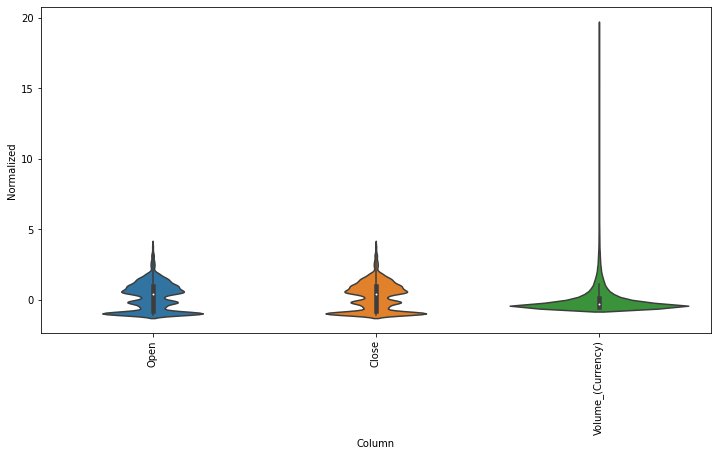

In [12]:
train_df, val_df = split_data(bs_data)

train_df, val_df = normalize(train_df, val_df, bs_data, plot=True)

In [ ]:
class TimeSerie:

    def __init__(self, link: str, name: str, to_drop: list,
                 window_size: int=24):
        """
        Constructor

        Parameters:
          - link: to download the raw data
          - name: file name

        Instance attributes:
          - df: data frame to clean
          
        """

        self.df = self.clean_data(self.load_data(self.read_data(link, name)), to_drop)
        self.train_df, self.val_df, = self.split_data()
        self.normalize()
        self.train_df = self.to_window(self.train_df, window_size)
        self.val_df = self.to_window(self.val_df, window_size)
        self.window_size = window_size

    @staticmethod
    def read_data(link: str, name: str) -> str:
        """
        returns the csv path in whose the data frame will be stored
        """
        zip_path = tf.keras.utils.get_file(
        origin=link,
        fname=name,
        extract=True)
        csv_path, _ = os.path.splitext(zip_path)
        return csv_path

    @staticmethod
    def load_data(csv_path: str) -> pd.DataFrame:
        df = pd.read_csv(csv_path)
        print(type(df), type(tf.data.Dataset))
        return df
    
    def clean_data(self, df : pd.DataFrame, to_drop: list) -> np.ndarray:
        """
        prepare dataframe
        """     

        # converts unix sistem timestamp format datetime
        df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
        
        # set timestamp as index
        df = df.set_index('Timestamp')

        df = df.drop(to_drop, axis=1)

        df = df.reindex(columns=['Open', 'Close', 'Volume_(Currency)'])

        # resample data into hourly period
        df = df.resample("H").agg({
            "Open": "first",
            "Close": "last",
            "Volume_(Currency)": "sum",
        })

        df = df.dropna()
        df = df.iloc[-int((df.shape[0]/2)):]
        self.old = df
        return df.to_numpy()

    def split_data(self) -> tuple:
        print(type(self.df), type(tf.data.Dataset))

        n = len(self.df)
        train_df = self.df[0:int(n*0.7)]
        val_df = self.df[int(n*0.7):]

        return train_df, val_df
    
    def normalize(self):
        """
        Normalize data centering the mean = 0 and giving stddev = 1
        """
        train_mean = self.train_df.mean(axis=0)
        train_std = self.train_df.std(axis=0)

        self.train_df = (self.train_df - train_mean) / train_std
        self.val_df = (self.val_df - train_mean) / train_std

    def to_window(self, df: np.ndarray, window_size: int=24) -> tuple:
        """
        makes windows of (train, val) secuences
        """
        X, Y = [], []

        n = df.shape[0]

        for i in range(n):
            if i + window_size < n:
                slice_x = df[i: i + window_size]
                slice_y = df[i + window_size, -2]
                X.append(slice_x), Y.append(slice_y)
        return np.array(X), np.array(Y)


Forecast class which creates and performs training of a generic forecasting model.

In [ ]:
class Forecast:

    def __init__(self, TS: TimeSerie, batch_size: int=256, steps: int=800):
        self.TS = TS
        self.n = TS.train_df[0].shape[0]
        self.train_dataset = tf.data.Dataset.from_tensor_slices(
            self.TS.train_df).shuffle(self.n).batch(batch_size).repeat()
        self.val_dataset = tf.data.Dataset.from_tensor_slices(
            self.TS.val_df).batch(batch_size).repeat()
        self.model = self.create()
        self.history = False
        self.steps = steps
    
    def create(self):
        """
        create the model which would be used
        """
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Bidirectional(
            layer=tf.keras.layers.LSTM(64,
                                       input_shape=self.TS.val_df[0].shape[1:],
                                       activation='relu')
        ))
        model.add(tf.keras.layers.Dense(1))

        model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])
        return model
    
    def train(self, patience: int=2, MAX_EPOCHS: int=20):
        """
        performs the trainig
        """
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

        self.history = self.model.fit(self.train_dataset, epochs=MAX_EPOCHS,
                                      validation_data=self.val_dataset,
                                      callbacks=[early_stopping],
                                      steps_per_epoch=self.steps,
                                      validation_steps=int(self.steps / 2))
    
    def plot_goal(self, label='Close'):
        """
        plots the goal label which we want to predict
        """
        data = {'timestamp': self.TS.old.index.tolist(),
        label: self.TS.old[label]}

        plt.plot('timestamp', label, data=data)
        plt.xlabel('timestamp')
        plt.ylabel(label)
        plt.show()

    def plot_performance(self):
        """
        plots model's performance during training
        """
        if not self.history:
            raise TypeError('Make sure that the training was made')
        plt.plot(self.history.history['loss'], label='Training')
        plt.plot(self.history.history['val_loss'], label='Validation')
        plt.title('LSTM training loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
    
    def plot_1h_pred(self):
        """
        plot a prediction of one our in the future
        """
        if not self.history:
            raise TypeError('Make sure that the training was made')
        for i, (x, y) in enumerate(self.val_dataset.take(3)):
            x_plot = x[0, :, -2].numpy(),
            y = y[0].numpy()

            plt.plot(np.arange(self.TS.window_size), x_plot[0], label='prior values')
            plt.scatter(self.TS.window_size, y,
                        edgecolors='k', label='Label', c='#2ca02c', s=64)
            plt.scatter(self.TS.window_size, self.model.predict(x)[0],
                            marker='X', edgecolors='k', label='Prediction',
                            c='#ff7f0e', s=64)
            plt.title(f'{self.TS.window_size}hs window to predict next in batch {i}')
            plt.xlabel('hourly')
            plt.ylabel('normalized predicted value')
            plt.legend()
            plt.show()
    
    def plot_window_pred(self):
        """
        plot prediction of window size
        """
        if not self.history:
            raise TypeError('Make sure that the training was made')
        for i, (x, y) in enumerate(self.val_dataset.take(3)):
            y = y.numpy()

            batch = np.arange(1, y.shape[0] + 1)
            plt.figure(figsize=(12, 6))
            plt.plot(batch, y, 'o-', markersize=3, mfc='none', label='Labels')
            plt.plot(batch, self.model.predict(x).reshape(-1), 'o-', markersize=3,
                     mfc='none', label='Predictions')
            plt.title(f'{self.TS.window_size}hs window size prediction over batch {i}')
            plt.xlabel('hourly')
            plt.ylabel('standardized predicted value')
            plt.legend()

            plt.show()

Workout.

In [ ]:
if __name__ == '__main__':
    # download, load, split, and performs the windowing of the dataset
    link = 'https://drive.google.com/u/0/uc?id=15A-rLSrfZ0td7muSrYHy0WX9ZqrMweES&export=download&confirm=t&uuid=65654327-a73c-4d74-90dc-01919656d9af&at=ACjLJWl8U_PMnHMdCXik5eG3gHeW:1672794871934'
    name = 'bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv.zip'

    # downloading, cleaning and normalizing data
    time_serie = TimeSerie(link=link, name=name, to_drop=['Low', 'High', 'Volume_(BTC)', 'Weighted_Price'])


<class 'pandas.core.frame.DataFrame'> <class 'abc.ABCMeta'>
<class 'numpy.ndarray'> <class 'abc.ABCMeta'>


In [ ]:
forecast = Forecast(time_serie)

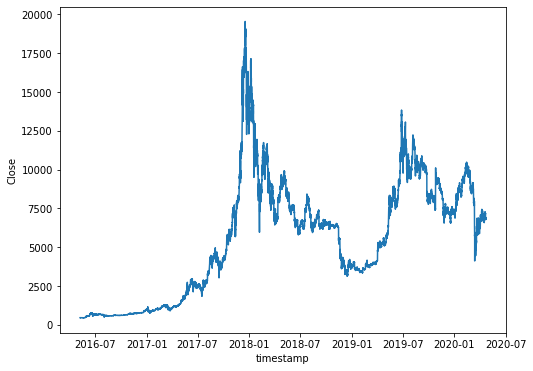

In [ ]:
forecast.plot_goal()

In [ ]:
forecast.train()

Epoch 1/20
800/800 [==============================] - 60s 68ms/step - loss: 0.0088 - mean_absolute_error: 0.0303 - val_loss: 0.0012 - val_mean_absolute_error: 0.0214
Epoch 2/20
800/800 [==============================] - 56s 70ms/step - loss: 8.6950e-04 - mean_absolute_error: 0.0153 - val_loss: 8.0896e-04 - val_mean_absolute_error: 0.0176
Epoch 3/20
800/800 [==============================] - 54s 68ms/step - loss: 6.9023e-04 - mean_absolute_error: 0.0139 - val_loss: 6.2640e-04 - val_mean_absolute_error: 0.0146
Epoch 4/20
800/800 [==============================] - 52s 65ms/step - loss: 5.6908e-04 - mean_absolute_error: 0.0126 - val_loss: 5.4286e-04 - val_mean_absolute_error: 0.0137
Epoch 5/20
800/800 [==============================] - 52s 65ms/step - loss: 4.9439e-04 - mean_absolute_error: 0.0116 - val_loss: 6.1404e-04 - val_mean_absolute_error: 0.0164
Epoch 6/20
800/800 [==============================] - 51s 63ms/step - loss: 4.7989e-04 - mean_absolute_error: 0.0117 - val_loss: 4.9840e-0

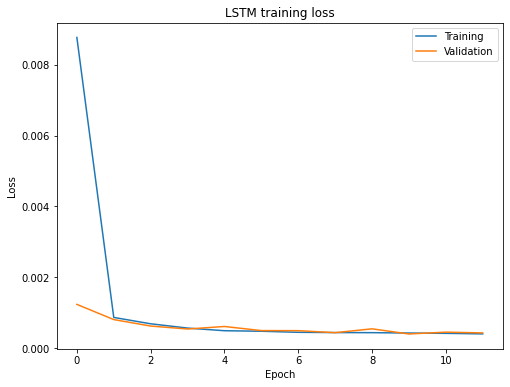

In [ ]:
forecast.plot_performance()

8/8 [==============================] - 0s 5ms/step


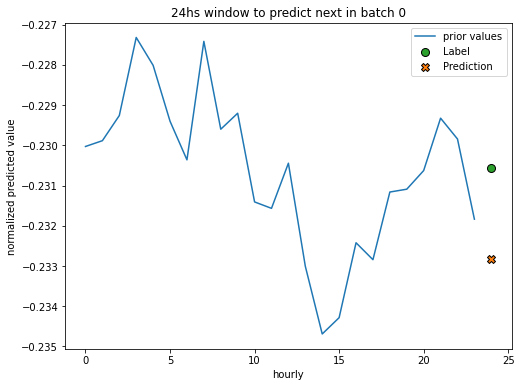

8/8 [==============================] - 0s 5ms/step


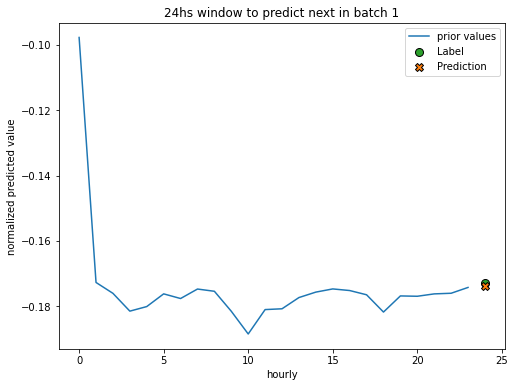

8/8 [==============================] - 0s 4ms/step


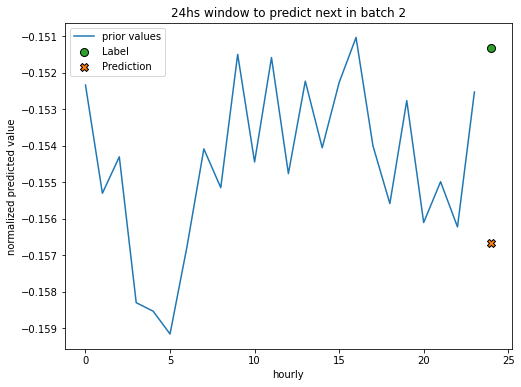

In [ ]:
forecast.plot_1h_pred()

8/8 [==============================] - 0s 4ms/step


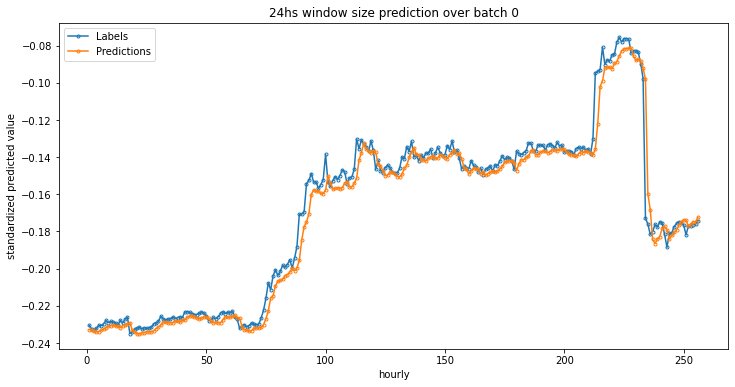

8/8 [==============================] - 0s 4ms/step


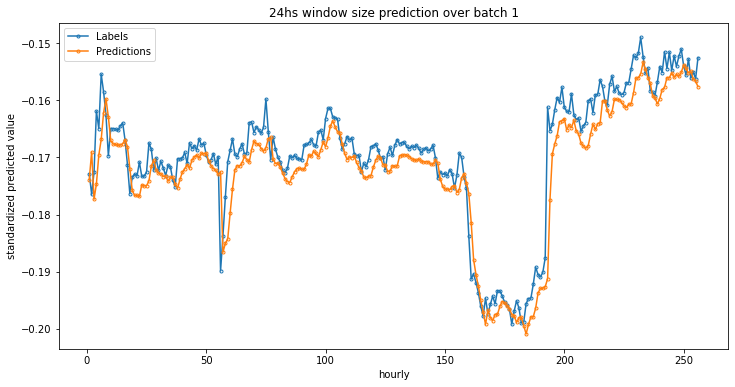

8/8 [==============================] - 0s 4ms/step


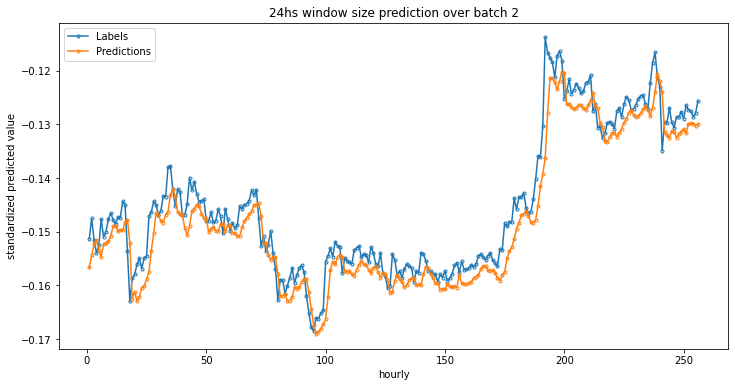

In [ ]:
forecast.plot_window_pred()